In [295]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import norm
from tqdm import trange, tqdm_notebook, tqdm

import anndata 

import scanpy as sc
import os
import copy

EPS = 1e-3


In [537]:
## Load adipose data
UCE_filtered_DIR = '/home/syyang/GitRepo/cs294/finalproject/data/UCEgenes_anndata'

adipose_sn_file = 'adata_with_infer_multiresleiden_toR_Xastypeinteger_proc.h5ad'
adipose_sn_ad = sc.read_h5ad(os.path.join(UCE_filtered_DIR,  adipose_sn_file) )



seurat_cluster_type = pd.read_csv('seurat_cluster_label_update0504.csv')
adipose_sn_ad.obs = adipose_sn_ad.obs.reset_index().merge(seurat_cluster_type, left_on='seurat_clusters', right_on='seurat_clusters', how='left').set_index('index')
adipose_sn_ad.obs['CellType_Category'] = adipose_sn_ad.obs['mapped_cell_type']


adipose_sn_ad.obs['mapped_cell_type'] = adipose_sn_ad.obs['mapped_cell_type'].astype('category') 


adipose_sn_ad.obs['sample'] = adipose_sn_ad.obs['sample'].astype('category')
adipose_sn_ad.obs['leiden_scVI_res0.9'] = adipose_sn_ad.obs['leiden_scVI_res0.9'].astype('category')
adipose_sn_ad.obs['seurat_clusters'] = adipose_sn_ad.obs['seurat_clusters'].astype('category')


ad_celltypes = adipose_sn_ad.obs['mapped_cell_type'].unique()

In [538]:
ad_celltypes

['0', 'Myeloid', 'Stromal', 'Endothelial', 'Epithelial', 'Lymphoid']
Categories (6, object): ['0', 'Endothelial', 'Epithelial', 'Lymphoid', 'Myeloid', 'Stromal']

In [977]:
# load human lung disease dataset (scRNAseq)
sc_adata_file = '/home/syyang/GitRepo/cs294/finalproject/UCE_downloads/human_lung_disease.h5ad'
human_lung_disease = sc.read_h5ad(sc_adata_file)

healthy_human_lung = human_lung_disease[human_lung_disease.obs['Disease_Identity'] == 'Control']
# remove multiplets
healthy_human_lung = healthy_human_lung[healthy_human_lung.obs['CellType_Category'] != 'Multiplet'] 
healthy_human_lung.obs['mapped_cell_type'] = healthy_human_lung.obs['CellType_Category']
healthy_human_lung.shape

sc_latent_center = healthy_human_lung.obsm['X_uce'].mean(axis=0)

# Calculate the latent center for each celltype (using scRNAseq data)

scRNAseq_celltype_latent_center = {}
scRNAseq_celltype_latent_var = {}
for type in ad_celltypes:
    if type != '0' :
        scRNAseq_celltype_latent_center[type] = healthy_human_lung[healthy_human_lung.obs['mapped_cell_type'] == type].obsm['X_uce'].mean(axis=0)
        scRNAseq_celltype_latent_var[type] = np.ones_like(scRNAseq_celltype_latent_center[type]) * 0.04
    else:
        scRNAseq_celltype_latent_center[type] =  np.zeros((1, 1280)) 
        scRNAseq_celltype_latent_var[type] = np.ones_like(scRNAseq_celltype_latent_center[type]) * 0.01
    
sc_latent_center = scRNAseq_celltype_latent_center['0']
sc_latent_center_var = scRNAseq_celltype_latent_var['0']

/tmp/ipykernel_343035/2164189612.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  healthy_human_lung.obs['mapped_cell_type'] = healthy_human_lung.obs['CellType_Category']


In [978]:
print(f'cell_type categories:" {ad_celltypes}')

cell_type_center_mean = torch.zeros((len(ad_celltypes) , 1280))
for i, type in enumerate(ad_celltypes):
    print(f"i = {i}, type = {type}")
    if type != '0':
        cell_type_center_mean[i] = torch.tensor(scRNAseq_celltype_latent_center[type])
    else:
        cell_type_center_mean[i] = cell_type_center_mean[1:].mean(axis=0)

        
        
cell_type_center_var = torch.zeros((len(ad_celltypes) , 1280))
for i, type in enumerate(ad_celltypes):
    cell_type_center_var[i] = torch.tensor(scRNAseq_celltype_latent_var[type])


cell_type categories:" ['0', 'Myeloid', 'Stromal', 'Endothelial', 'Epithelial', 'Lymphoid']
Categories (6, object): ['0', 'Endothelial', 'Epithelial', 'Lymphoid', 'Myeloid', 'Stromal']
i = 0, type = 0
i = 1, type = Myeloid
i = 2, type = Stromal
i = 3, type = Endothelial
i = 4, type = Epithelial
i = 5, type = Lymphoid


In [979]:
# Construct anndata with center UCE latent space for visualization
cell_type_ad = anndata.AnnData(X=adipose_sn_ad[:len(ad_celltypes), :].X, obs=adipose_sn_ad[:len(ad_celltypes), ].obs)
cell_type_ad.obs['mapped_cell_type'] = ad_celltypes.tolist()
cell_type_ad.obsm['X_uce'] = cell_type_center_mean

In [980]:
simulate_cell_type_centroid = torch.distributions.Normal(cell_type_center_mean, cell_type_center_var.sqrt()  ).sample(torch.Size([1000])).view(-1, 1280)

n_samples = simulate_cell_type_centroid.shape[0]

simulated_cell_type_ad = anndata.AnnData(X=adipose_sn_ad[:n_samples, :].X, obs=adipose_sn_ad[:n_samples, ].obs)
simulated_cell_type_ad.obs['mapped_cell_type'] = ad_celltypes.tolist() * int(n_samples / len(ad_celltypes))
simulated_cell_type_ad.obs['CellType_Category'] = simulated_cell_type_ad.obs['mapped_cell_type']
simulated_cell_type_ad.obs['Subclass_Cell_Identity'] = simulated_cell_type_ad.obs['mapped_cell_type']
simulated_cell_type_ad.obsm['X_uce'] = simulate_cell_type_centroid

In [981]:
simulated_cell_type_ad.obsm['X_uce'].min(axis=0), simulated_cell_type_ad.obsm['X_uce'].max(axis=0)

(torch.return_types.min(
 values=tensor([-0.8136, -0.6738, -0.7860,  ..., -0.7851, -0.6964, -0.7885]),
 indices=tensor([2651, 4779, 4563,  ...,  371, 4841, 1715])),
 torch.return_types.max(
 values=tensor([0.6145, 0.6613, 0.7882,  ..., 0.8942, 0.7332, 0.6974]),
 indices=tensor([1479, 2614, 2050,  ..., 2373,  811, 2295])))

In [982]:
scconcat_ad = anndata.concat([healthy_human_lung, simulated_cell_type_ad], label="dataset", keys=[ "scRNAseq", "celltype_center"])
scconcat_ad.obsm['syy_VAE'] = np.concatenate((healthy_human_lung.obsm['X_uce'], simulated_cell_type_ad.obsm['X_uce']), axis=0)
sc.pp.neighbors(scconcat_ad, use_rep='syy_VAE')
sc.tl.umap(scconcat_ad)


/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


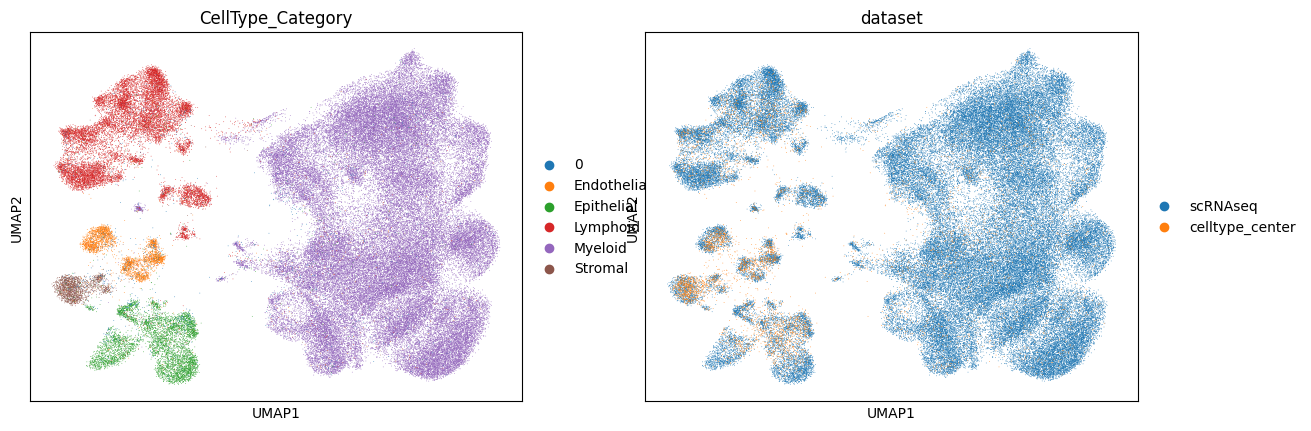

In [983]:
sc.pl.umap(scconcat_ad, color=['CellType_Category', 'dataset'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


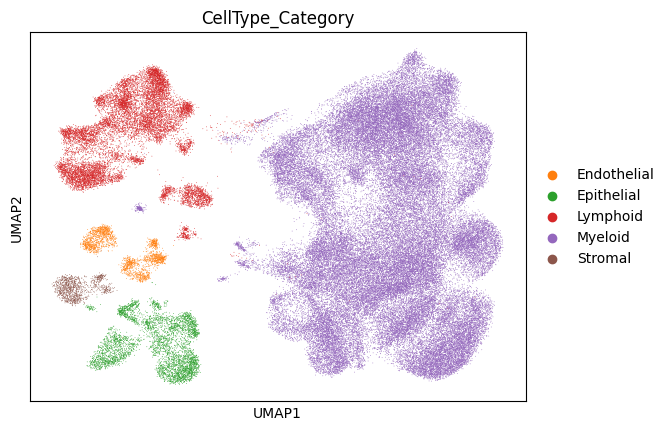

In [984]:
sc.pl.umap(scconcat_ad[scconcat_ad.obs['dataset'] == 'scRNAseq'], color=['CellType_Category'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


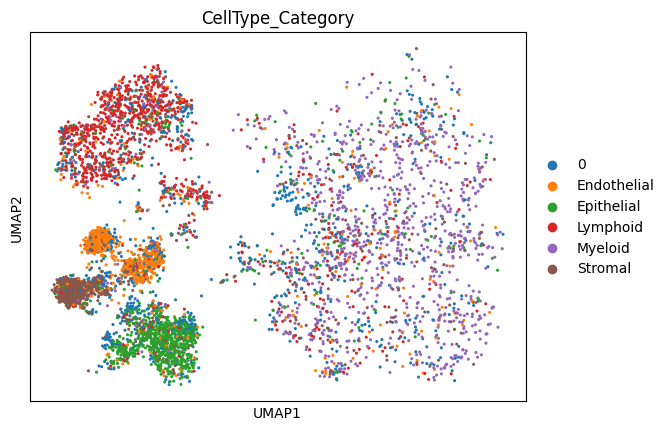

In [985]:
sc.pl.umap(scconcat_ad[scconcat_ad.obs['dataset'] == 'celltype_center'], color=['CellType_Category'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


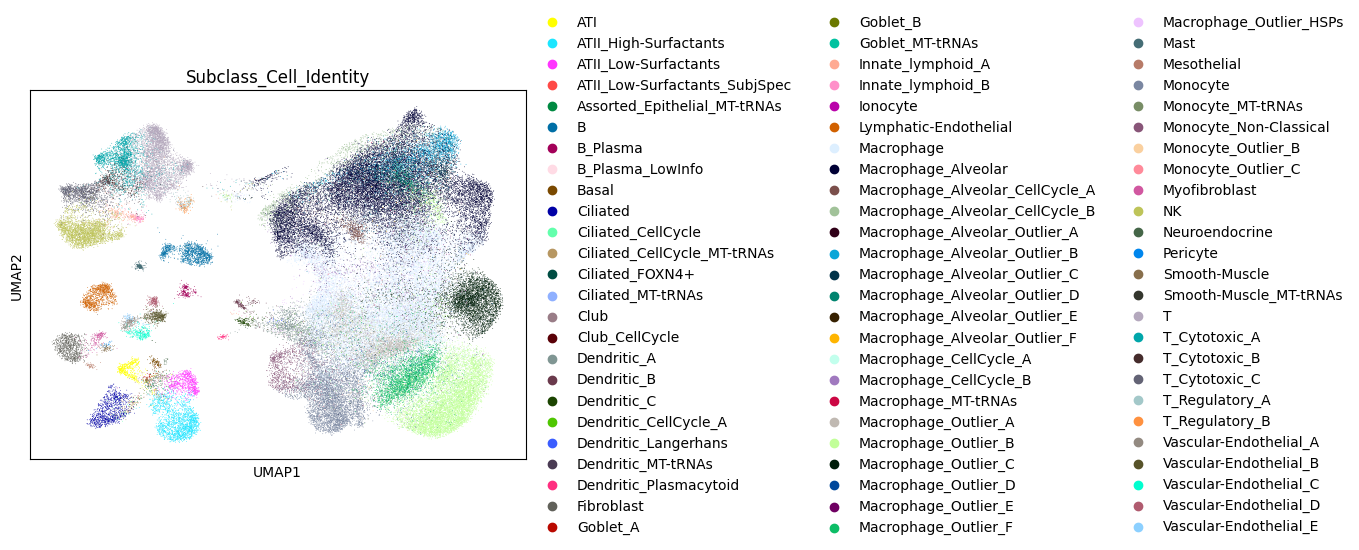

In [986]:
sc.pl.umap(scconcat_ad[scconcat_ad.obs['dataset'] == 'scRNAseq'], color=['Subclass_Cell_Identity'] )

In [987]:
class scDataset(Dataset):
    def __init__(self, adata):
        """
        adata: AnnData object
        cat: from adata.obs['sample']
        labels: from adata.obs['leiden_scVI_res0.9'] --> Need to be changed to cell type
        """
        self.obs = adata.obs
        self.data = torch.log(torch.tensor(adata.layers['counts'].toarray() + 1. ))  # log transform
        #self.data =  torch.tensor(adata.layers['counts'].toarray())
        self.local_library_mean = self.data.sum(axis=1)
        self.local_library_var = torch.tensor([1.])
        
        self.n_cat = adata.obs['sample'].nunique()
        self.cat = torch.tensor(adata.obs['sample'].cat.codes.values).to(torch.int64) # sample labels
        
        self.n_labels = adata.obs['mapped_cell_type'].nunique() #- 1 # -1 because '0' is unknown 
        self.labels = torch.tensor(adata.obs['mapped_cell_type'].cat.codes.values).to(torch.int64)   # cell type labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # onehot encode `cat` and `labels`
        cat_onehot = F.one_hot(self.cat[idx], self.n_cat)
        label_onehot = F.one_hot(self.labels[idx], self.n_labels)
        
        return self.data[idx], cat_onehot, label_onehot, self.local_library_mean[idx], self.local_library_var 
    

# Example
# adipose_dataset = scDataset(adipose_sn_ad)
# data_loader = DataLoader(adipose_dataset, batch_size=10, shuffle=False)
# a = next(iter(data_loader))
    

In [988]:
class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.1):
        super(LinearBlock, self).__init__()
        layers = [
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim, momentum=.01, eps=0.001),
            nn.ReLU(),
        ]
        if dropout:
            layers.append(nn.Dropout(p=dropout))
            
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

class Encoder_x(nn.Module):
    """_summary_
        This encodes the latent space of the data vector x
    Args:
        nn (_type_): _description_
        latent_dim: 1280, same as the latent_dim in the UCE model (UCE: \ref[Rosen, Yanay, et al. "Universal Cell Embeddings: A Foundation Model for Cell Biology." bioRxiv (2023): 2023-11.])
        
    """
    def __init__(self, input_dim, total_cell_type, latent_dim=1280, hidden_dim=1280, hidden_layers=1, encode_celltype=False):
        super(Encoder_x, self).__init__()
        
        self.encode_celltype = encode_celltype
        self.laten_dim = latent_dim
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        
        if encode_celltype:
            self.encoder_cell_type = Encoder_cell_type(input_dim=total_cell_type, latent_dim=latent_dim, hidden_dim=hidden_dim, hidden_layers=1) 
        
        self.linear_mean = nn.Linear(latent_dim, latent_dim * total_cell_type )
        self.linear_var = nn.Linear(latent_dim, latent_dim * total_cell_type )

    def forward(self, x, cell_type_one_hot=None): 
        x = self.layers(x)
        if self.encode_celltype:
            x += self.encoder_cell_type(cell_type_one_hot)
        qz_mean = self.linear_mean(x)
        qz_var = torch.exp(self.linear_var(x))
        qz_mean = torch.stack(torch.split(qz_mean, self.laten_dim, dim=-1), dim=1) # shape is of [batch_size x n_cell_type x latent_dim]
        qz_var = torch.stack(torch.split(qz_var, self.laten_dim, dim=-1), dim=1) # shape is of [batch_size x n_cell_type x latent_dim]
        #z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())
        return qz_mean, qz_var #, z_dist
    
    
class Encoder_claffifier(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=30, hidden_layers=1):
        super(Encoder_claffifier, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -2) + [[hidden_dim, output_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        
        self.softmax = nn.Sequential(nn.Linear(output_dim, output_dim), nn.Softmax(dim=-1))
    def forward(self, x):
        x = self.layers(x)
        prob = self.softmax(x) 
        return prob

class Encoder_cell_type(nn.Module):
    """_summary_
        This encodes the cell type, which is affected by observation x 
        
    Args:
        nn (_type_): _description_
        latent_dim: 1
        
    """
    def __init__(self, input_dim, latent_dim=1, hidden_dim=20, hidden_layers=1):
        super(Encoder_cell_type, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        
        self.celltype_zm = nn.Linear(latent_dim, latent_dim)

    def forward(self, cell_type_one_hot):
        zm = self.layers(cell_type_one_hot)
        zm = self.celltype_zm(zm)
        return zm

    
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=1280, hidden_layers=1):
        super(Decoder, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -1) 
        self.decoder = nn.Sequential(
            *[LinearBlock(dim[0], dim[1], dropout=None) for dim in layer_dims]
        )
        
        self.px_dropout_decoder = nn.Linear(hidden_dim, output_dim)  # the logit of the dropout rate
        self.px_scale_decoder = nn.Sequential(nn.Linear(hidden_dim, output_dim),
                                      nn.Softmax(dim=-1))
        self.px_dispersion_decoder = nn.Linear(hidden_dim, output_dim)
        

    def forward(self, z, library, cat_one_hot):
        
        input = torch.cat([z, cat_one_hot], dim=1) # cat_index is the one_hot encoded cell_type_index
        x = self.decoder(input)
        
        px_scale = self.px_scale_decoder(x)
        #px_rate = torch.exp(library) * px_scale  # encode library size
        px_rate = library * px_scale  # use observed library size

        
        px_dispersion = self.px_dispersion_decoder(x)
        px_dropout = self.px_dropout_decoder(x)
        
        #px_dispersion = torch.clamp(torch.exp(px_dispersion), min=EPS)  # Clipping at the minimum does not seem to solve the NAN problem in lgammaBACK0
        px_dispersion = torch.exp(px_dispersion)  # positive value
        
        
        
        return px_rate, px_dispersion, px_dropout 
    
    

    
def log_zinb_positive(
    x: torch.Tensor,
    mu: torch.Tensor,
    theta: torch.Tensor,
    pi: torch.Tensor,
    eps: float = 1e-8,
) -> torch.Tensor:
    """
    Took From `https://github.com/scverse/scvi-tools`  
     
    Log likelihood (scalar) of a minibatch according to a zinb model.

    Parameters
    ----------
    x
        Data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    pi
        logit of the dropout parameter (real support) (shape: minibatch x vars)
    eps
        numerical stability constant

    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """
    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless
    # of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(1, theta.size(0))  # In this case, we reshape theta for broadcasting

    # Uses log(sigmoid(x)) = -softplus(-x)
    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)
    

    res = mul_case_zero + mul_case_non_zero

    return res



In [989]:
class snRNAseqVAE(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim, encode_hidden_dim, decode_hidden_dim, total_cat, total_cell_type, hard_classifier = False, alpha = 0.1, encode_celltype=False, device='cpu'):
        """_summary_

        Args:
            input_dim (_type_): _description_
            output_dim (_type_): _description_
            latent_dim (_type_): _description_
            encode_hidden_dim (_type_): _description_
            decode_hidden_dim (_type_): _description_
            total_cat (_type_): _description_
            total_cell_type (_type_): _description_
            alpha (float, optional): _description_. Defaults to 0.1. Penalty for cell-type level center mean on latent space 
            encode_celltype (float, optional): _description_. Encode cell type or not. Defaults to False.
            
        """
        super(snRNAseqVAE, self).__init__()
        
        self.device = device
        self.encode_celltype = encode_celltype 
        self.alpha = torch.tensor(alpha).to(device) # 
        self.hard_classifier = hard_classifier
        
        self.total_cat = total_cat
        self.total_cell_type = total_cell_type # total_cell_type = total-known-cell-types + 1 (for unknown cell type: 0) 
                
                
        self.encoder_x = Encoder_x(input_dim, total_cell_type, latent_dim, hidden_dim=encode_hidden_dim,  hidden_layers=2, encode_celltype=encode_celltype)
        
        self.encoder_classifier = Encoder_claffifier(input_dim, total_cell_type, hidden_dim=30, hidden_layers=2)
        
        decoder_input_dim = latent_dim + total_cat  # total_cat is the total number of categories in the cat_index, indicates datasets 
        self.decoder = Decoder(decoder_input_dim, output_dim, hidden_dim=decode_hidden_dim, hidden_layers=1)
    
    def _process_prob(self, prob):
        # Add random noise to avoid multiple values being the same
        noise = torch.rand(prob.shape)
        noise = -torch.log(-torch.log(noise + 1e-8) + 1e-8)
        y = torch.log(prob + 1e-8) + noise.to(self.device) 
        y_hard = (y == torch.max(y, dim=1, keepdim=True)[0]).type(y.dtype)
        y = (y_hard - y).detach() + y
        return y         
        
    def _inference(self, x, cat_one_hot, cell_type_one_hot, l):
        if self.encode_celltype:
            qz_mean, qz_var = self.encoder_x(x, cell_type_one_hot)  # [batch_size x n_cell_type x latent_dim]
        else:
            qz_mean, qz_var = self.encoder_x(x)
        
        prob = self.encoder_classifier(x)
        if self.hard_classifier:
            y_hat = self._process_prob(prob)
        else:
            y_hat = prob
                
        qz_mean = (torch.matmul(y_hat[:, None, :], qz_mean)).squeeze() # [batch_size x latent_dim]
        qz_var = (torch.matmul(y_hat[:, None, :], qz_var)).squeeze() # [batch_size x latent_dim]
        z = torch.distributions.Normal(qz_mean, qz_var.sqrt()).rsample()
        
        px_rate, px_dispersion, px_dropout  = self.decoder(z, l, cat_one_hot)

        return y_hat, qz_mean, qz_var, px_rate, px_dispersion, px_dropout 
    
    def get_latent(self, x, cell_type_one_hot=None):
        if self.encode_celltype:
            qz_mean, qz_var = self.encoder_x(x, cell_type_one_hot)
        else:
            qz_mean, qz_var = self.encoder_x(x)
        
        prob = self.encoder_classifier(x)
        y_hat = self._process_prob(prob)
        
        qz_mean = (torch.matmul(y_hat[:, None, :], qz_mean)).squeeze()
        return qz_mean
    
    def forward(self, x, local_l_mean, cat_one_hot, cell_type_one_hot, cell_type_mask, cell_type_center_mean, cell_type_center_var):
        """_summary_

        Args:
            x (_type_): _description_
            local_l_mean (_type_): shape of [batch_size, 1]
            cat_one_hot (_type_): shape of [batch_size, n_cat]
            cell_type_one_hot (_type_): shape of [batch_size, n_cell_types]
            cell_type_mask: shape of [batch_size, 1]
            cell_type_center_mean: shape of [n_cell_types, latent_dim]

        Returns:
            _type_: _description_
        """

        
        y_hat, qz_mean, qz_var, px_rate, px_dispersion, px_dropout = self._inference(x, cat_one_hot, cell_type_one_hot, local_l_mean)
        z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())


        #kl_z = torch.distributions.kl.kl_divergence(z_dist, torch.distributions.Normal(torch.zeros_like(qz_mean), torch.ones_like(qz_var))).sum(axis=1)
        #kl_z = torch.distributions.kl.kl_divergence(z_dist,  torch.distributions.Normal(  torch.matmul(y_hat, cell_type_center_mean),  0.05 * torch.ones_like(qz_var))).sum(axis=1)
        kl_z = torch.distributions.kl.kl_divergence(z_dist,  \
            torch.distributions.Normal(  torch.matmul(y_hat, cell_type_center_mean), torch.matmul(y_hat, cell_type_center_var.sqrt()) ) \
                ).sum(axis=1)
        
        reconst_loss = -log_zinb_positive(x, px_rate, px_dispersion, px_dropout).sum(axis=-1)
        
        crossentropy = nn.CrossEntropyLoss(reduction='none')
        classifier_loss = (crossentropy(y_hat, cell_type_one_hot) * cell_type_mask.squeeze()).sum()

        return (reconst_loss +  1. * kl_z + classifier_loss).mean()
        #return (reconst_loss + kl_z ).mean() #, reconst_loss.mean(), kl_z.mean(), kl_l.mean()

In [990]:
## Training 
def trainning(model, scheduler, train_loader, cell_type_center_mean, cell_type_center_var, device, optimizer, n_epochs=100, mask_rate=0.4, detect_anomaly=False):
    mask_sample = torch.distributions.Bernoulli(torch.tensor([mask_rate]))
    model = model.to(device)
    model.train()
    train_loss = []
    
    cell_type_center_mean = cell_type_center_mean.to(device)
    cell_type_center_var = cell_type_center_var.to(device)
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_loss = 0
        N = 0
        for i, data in enumerate(train_loader):
            x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
            batch_size = x.size(0)
            
            x = x.to(device)
            cat_onehot = cat_onehot.to(device)
            
            label_onehot = label_onehot.to(device).float()
            cell_type_mask = mask_sample.sample((batch_size, )).to(device) # size of [batch_size, 1]
            
            local_library_mean = local_library_mean.to(device).view((-1,1))  # size of [batch_size, 1]
            local_library_var = local_library_var.to(device).view((-1,1))  # size of [batch_size, 1]
            
            optimizer.zero_grad()
            loss = model(x, local_library_mean, cat_onehot, label_onehot, cell_type_mask, cell_type_center_mean, cell_type_center_var) 
            if detect_anomaly:
                with torch.autograd.detect_anomaly():
                    loss.backward()
            else:
                loss.backward()
            #loss.backward()
            total_loss += loss.item() * x.size(0)
            N += x.size(0)
            optimizer.step()
        scheduler.step(loss)
        print("Epoch: ", epoch, "Loss: ", total_loss/N )
        train_loss.append(total_loss/N)
        
    return train_loss, loss

In [991]:
## Data
train_data = adipose_sn_ad#[adipose_sn_ad.obs['mapped_cell_type'] != '0', ]
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=True)

## set model 
total_cat = adipose_dataset.obs['sample'].nunique()
#total_cell_type = adipose_dataset.obs['mapped_cell_type'].nunique() - 1 # -1 because '0' is unknown
total_cell_type = adipose_dataset.obs['mapped_cell_type'].nunique() 

cell_type_center_mean = cell_type_center_mean#[1:]
cell_type_center_var = cell_type_center_var#[1:]

output_dim  = adipose_dataset.data.shape[1]

model = snRNAseqVAE(input_dim=adipose_dataset.data.shape[1], output_dim=output_dim, \
    latent_dim=1280, encode_hidden_dim=2000, decode_hidden_dim=2000, total_cat=total_cat, total_cell_type=total_cell_type, alpha=1., encode_celltype=False, device='cuda')  # Use cell type encoding

optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=0.01, weight_decay=0.016)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

train_loss, _ = trainning(model, scheduler, data_loader, cell_type_center_mean, cell_type_center_var, device='cuda', optimizer=optimizer, n_epochs=40, mask_rate=.4)

  2%|▎         | 1/40 [00:05<03:43,  5.73s/it]

Epoch:  0 Loss:  4847.0247651860955


  5%|▌         | 2/40 [00:10<03:15,  5.14s/it]

Epoch:  1 Loss:  3807.366036747279


  8%|▊         | 3/40 [00:15<03:07,  5.07s/it]

Epoch:  2 Loss:  3749.1910633558637


 10%|█         | 4/40 [00:20<03:01,  5.03s/it]

Epoch:  3 Loss:  3721.4570346789415


 12%|█▎        | 5/40 [00:25<02:51,  4.91s/it]

Epoch:  4 Loss:  3680.066634617495


 15%|█▌        | 6/40 [00:30<02:47,  4.94s/it]

Epoch:  5 Loss:  3661.528458841731


 18%|█▊        | 7/40 [00:35<02:42,  4.94s/it]

Epoch:  6 Loss:  3636.6297936600245


 20%|██        | 8/40 [00:39<02:35,  4.87s/it]

Epoch:  7 Loss:  3621.0885030339273


 22%|██▎       | 9/40 [00:44<02:32,  4.91s/it]

Epoch:  8 Loss:  3603.5919868383517


 25%|██▌       | 10/40 [00:49<02:25,  4.86s/it]

Epoch:  9 Loss:  3581.7322950041694


 28%|██▊       | 11/40 [00:54<02:22,  4.90s/it]

Epoch:  10 Loss:  3549.053451023745


 30%|███       | 12/40 [00:59<02:18,  4.93s/it]

Epoch:  11 Loss:  3529.507907138782


 32%|███▎      | 13/40 [01:04<02:11,  4.87s/it]

Epoch:  12 Loss:  3503.853412756759


 35%|███▌      | 14/40 [01:09<02:07,  4.91s/it]

Epoch:  13 Loss:  3478.880851831329


 38%|███▊      | 15/40 [01:13<02:01,  4.86s/it]

Epoch:  14 Loss:  3467.08411536056


 40%|████      | 16/40 [01:18<01:57,  4.90s/it]

Epoch:  15 Loss:  3446.6219173817153


 42%|████▎     | 17/40 [01:23<01:53,  4.93s/it]

Epoch:  16 Loss:  3425.7856253291784


 45%|████▌     | 18/40 [01:28<01:47,  4.88s/it]

Epoch:  17 Loss:  3404.650999604986


 48%|████▊     | 19/40 [01:33<01:43,  4.92s/it]

Epoch:  18 Loss:  3402.0442882066363


 50%|█████     | 20/40 [01:38<01:37,  4.86s/it]

Epoch:  19 Loss:  3392.8514952927494


 52%|█████▎    | 21/40 [01:43<01:33,  4.91s/it]

Epoch:  20 Loss:  3381.485539468487


 55%|█████▌    | 22/40 [01:48<01:28,  4.94s/it]

Epoch:  21 Loss:  3380.6105662142295


 57%|█████▊    | 23/40 [01:53<01:22,  4.88s/it]

Epoch:  22 Loss:  3380.237162729328


 60%|██████    | 24/40 [01:58<01:18,  4.92s/it]

Epoch:  23 Loss:  3372.5255881320227


 62%|██████▎   | 25/40 [02:02<01:13,  4.87s/it]

Epoch:  24 Loss:  3370.288504268346


 65%|██████▌   | 26/40 [02:08<01:08,  4.91s/it]

Epoch:  25 Loss:  3366.283819648657


 68%|██████▊   | 27/40 [02:13<01:04,  4.94s/it]

Epoch:  26 Loss:  3368.190260983585


 70%|███████   | 28/40 [02:17<00:58,  4.88s/it]

Epoch:  27 Loss:  3363.812594638782


 72%|███████▎  | 29/40 [02:22<00:54,  4.92s/it]

Epoch:  28 Loss:  3354.8601561128426


 75%|███████▌  | 30/40 [02:27<00:48,  4.87s/it]

Epoch:  29 Loss:  3360.251754932189


 78%|███████▊  | 31/40 [02:32<00:44,  4.91s/it]

Epoch:  30 Loss:  3361.0930045481477


 80%|████████  | 32/40 [02:37<00:39,  4.94s/it]

Epoch:  31 Loss:  3355.192976705144


 82%|████████▎ | 33/40 [02:42<00:34,  4.89s/it]

Epoch:  32 Loss:  3346.9810647000086


 85%|████████▌ | 34/40 [02:47<00:29,  4.93s/it]

Epoch:  33 Loss:  3351.2676041849545


 88%|████████▊ | 35/40 [02:52<00:24,  4.87s/it]

Epoch:  34 Loss:  3345.9442138671875


 90%|█████████ | 36/40 [02:57<00:19,  4.92s/it]

Epoch:  35 Loss:  3346.3541328344454


 92%|█████████▎| 37/40 [03:02<00:14,  4.95s/it]

Epoch:  36 Loss:  3346.4179701215767


 95%|█████████▌| 38/40 [03:06<00:09,  4.88s/it]

Epoch:  37 Loss:  3342.4059612831375


 98%|█████████▊| 39/40 [03:11<00:04,  4.92s/it]

Epoch:  38 Loss:  3344.246874177054


100%|██████████| 40/40 [03:16<00:00,  4.92s/it]

Epoch:  39 Loss:  3336.70862707931


In [992]:
#torch.save(model, '/home/syyang/GitRepo/yyyyvae/script/model_44epo_20240430.pth')
#model = torch.load('/home/syyang/GitRepo/yyyyvae/script/model_44epo_20240430.pth')
#_, loss = trainning(model, scheduler, data_loader, cell_type_center_mean, cell_type_center_var, device='cuda', optimizer=optimizer, n_epochs=20, mask_rate=1., detect_anomaly=True)

In [993]:
# Get latent representation of the data
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=False)
z = []
model.eval()
with torch.no_grad():
    for i, data in enumerate(data_loader):
        x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
        x = x.to('cuda')
        cat_onehot = cat_onehot.to('cuda')
        #label_onehot = label_onehot.to('cuda').float() * 0  # mask label_onehot
        label_onehot = label_onehot.to('cuda').float()
        local_library_mean = local_library_mean.to('cuda').view((-1,1))
        local_library_var = local_library_var.to('cuda').view((-1,1))
        qz_mean= model.get_latent(x)  # with cell type encoding
        #qz_mean, _ = model.encoder_x(x)
        z.append(qz_mean.cpu().detach())

In [994]:
train_data_2 = train_data.copy()
train_data_2.obsm['syy_VAE'] = torch.cat(z).numpy()
sc.pp.neighbors(train_data_2, use_rep='syy_VAE')
sc.tl.umap(train_data_2)


train_data_2.obsm['syy_VAE'].shape

(71200, 1280)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


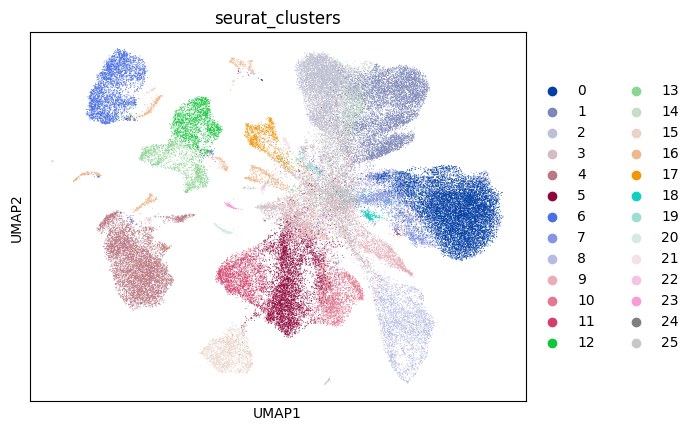

In [995]:
sc.pl.umap(train_data_2, color=['seurat_clusters'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


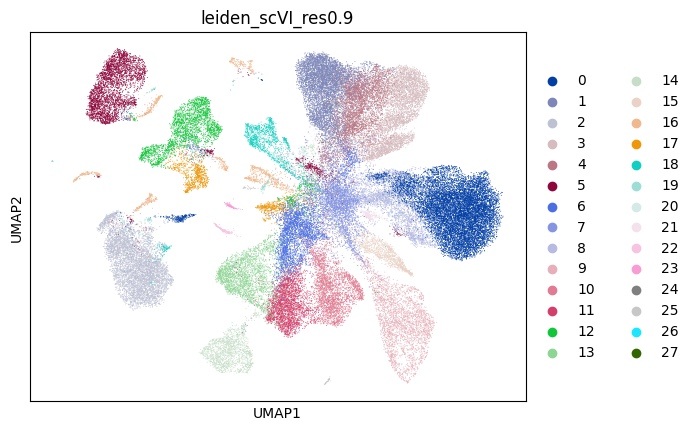

In [996]:
sc.pl.umap(train_data_2, color=['leiden_scVI_res0.9'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


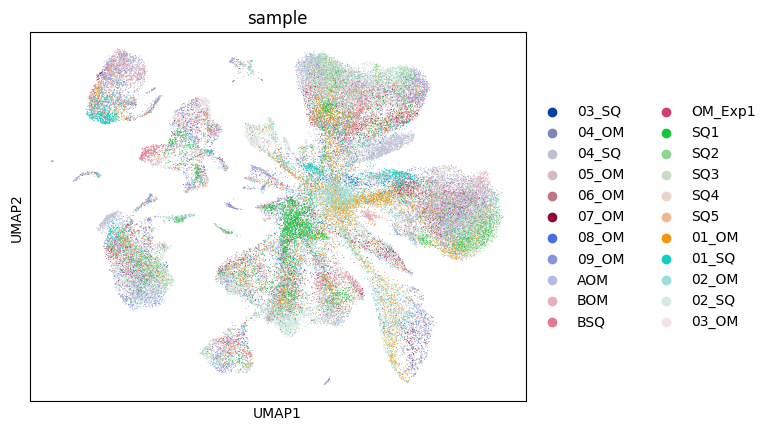

In [997]:
sc.pl.umap(train_data_2, color=['sample'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


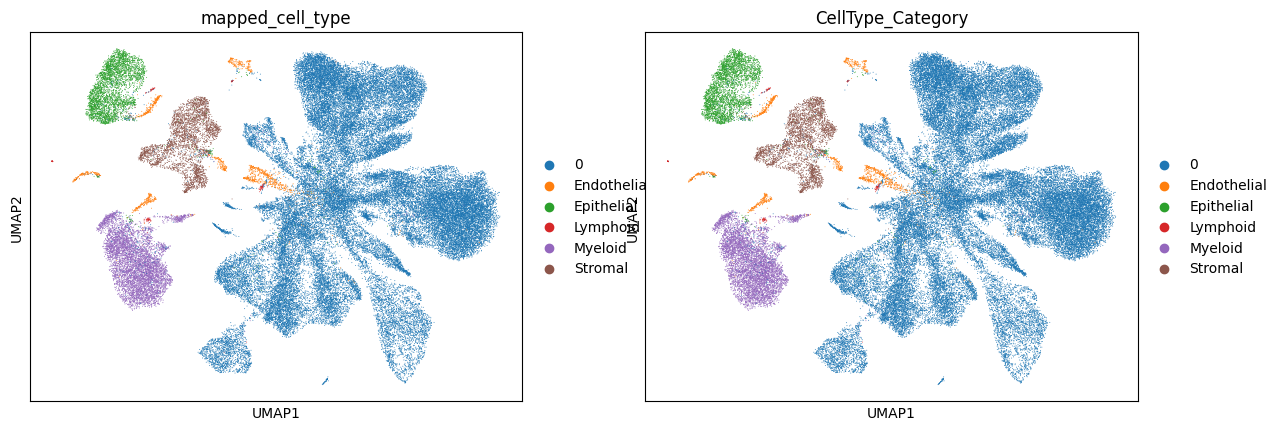

In [998]:
sc.pl.umap(train_data_2, color=['mapped_cell_type', 'CellType_Category'] )

## concatenate scRNAseq & snRNAseq 

In [999]:
concat_ad = anndata.concat([train_data_2, healthy_human_lung, simulated_cell_type_ad], label="dataset", keys=["snRNAseq", "scRNAseq", "celltype_center"])
concat_ad.obsm['syy_VAE'] = np.concatenate((train_data_2.obsm['syy_VAE'], healthy_human_lung.obsm['X_uce'], simulated_cell_type_ad.obsm['X_uce']), axis=0)
#concat_ad = concat_ad[concat_ad.obs['CellType_Category'] != 'Myeloid']

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [1000]:
sc.pp.neighbors(concat_ad, use_rep='syy_VAE')
sc.tl.umap(concat_ad)


/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


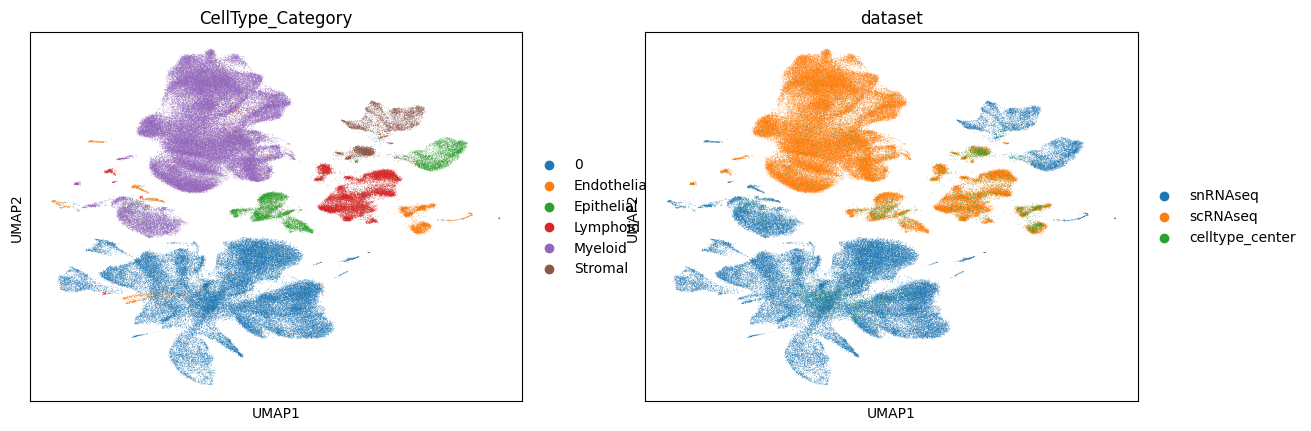

In [1001]:
sc.pl.umap(concat_ad, color=['CellType_Category', 'dataset'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


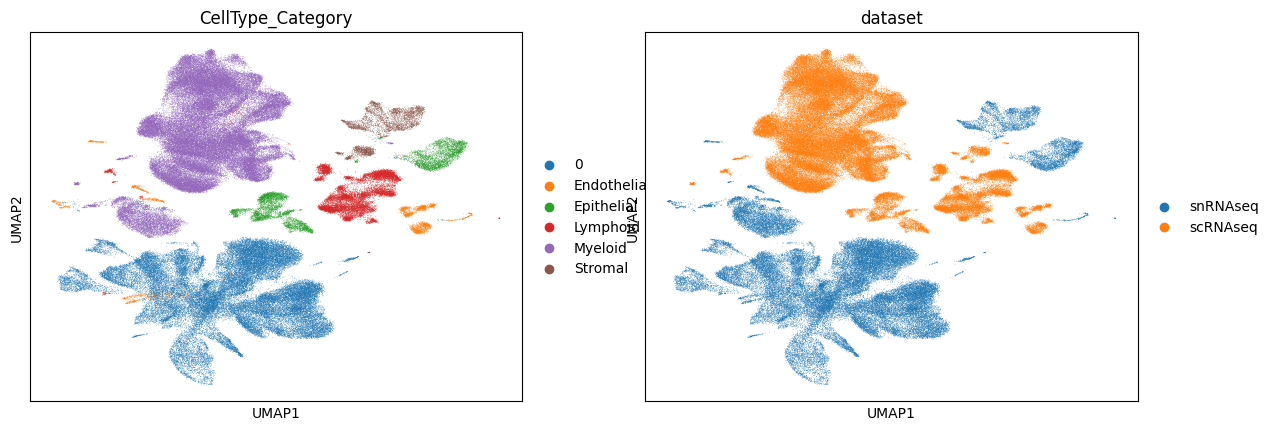

In [1002]:
sc.pl.umap(concat_ad[concat_ad.obs['dataset'] != 'celltype_center'], color=['CellType_Category', 'dataset'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


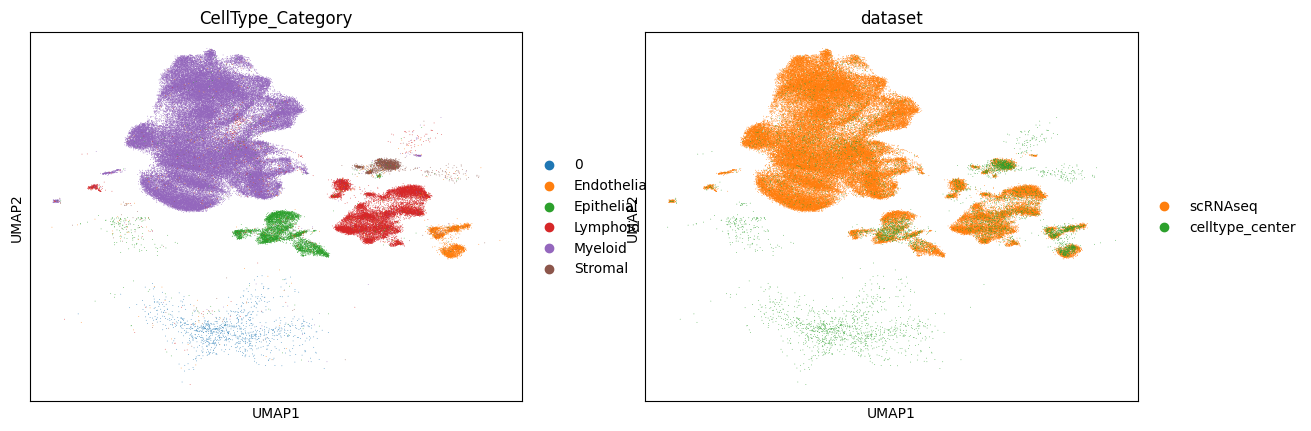

In [1003]:
sc.pl.umap(concat_ad[concat_ad.obs['dataset'] != 'snRNAseq'], color=['CellType_Category', 'dataset'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


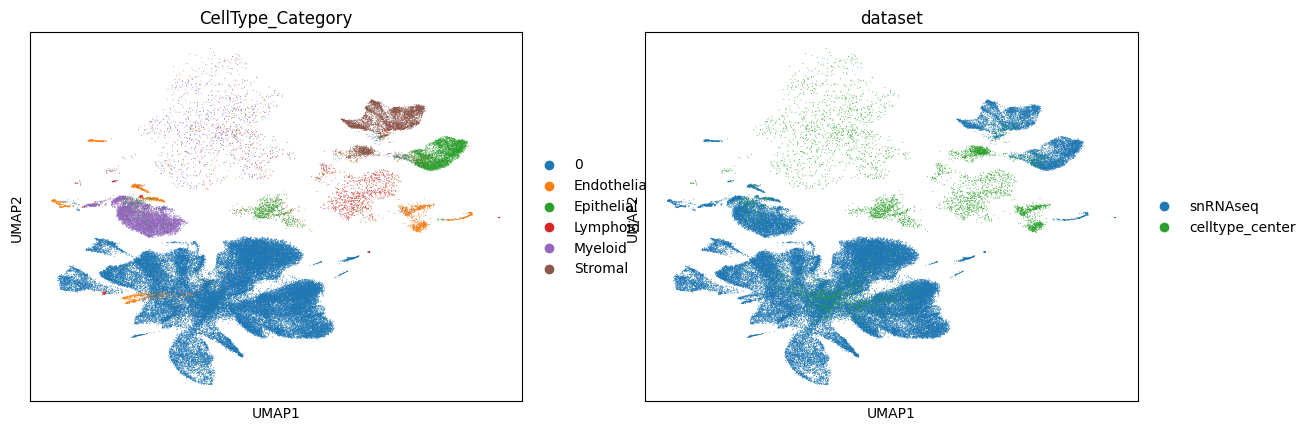

In [1004]:
sc.pl.umap(concat_ad[concat_ad.obs['dataset'] != 'scRNAseq'], color=['CellType_Category', 'dataset'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


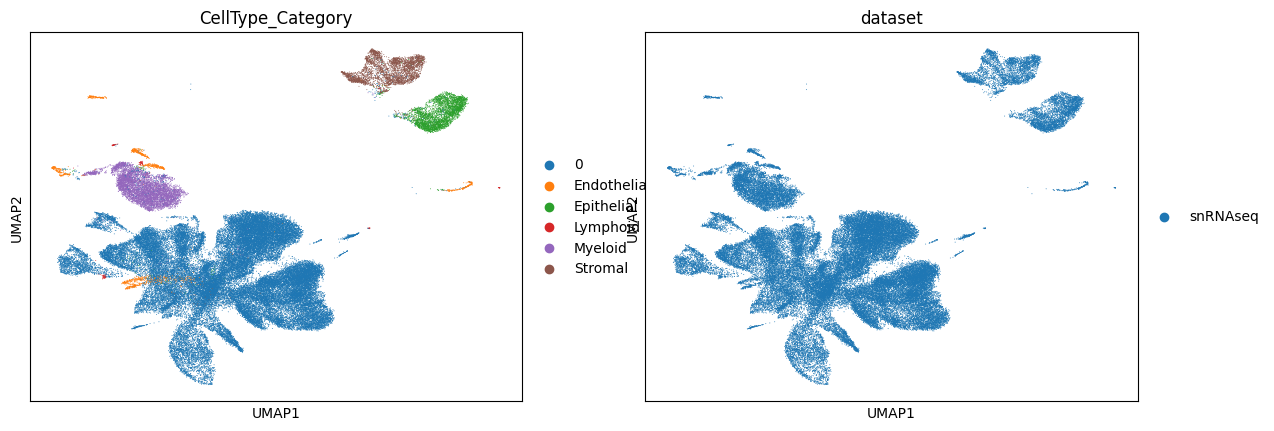

In [1005]:
sc.pl.umap(concat_ad[concat_ad.obs['dataset'] == 'snRNAseq'], color=['CellType_Category', 'dataset'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


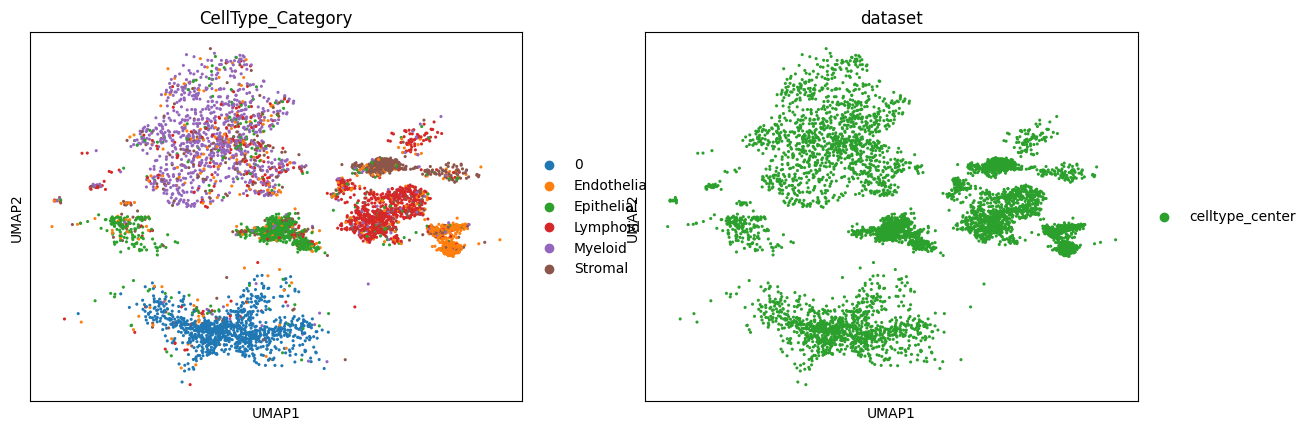

In [1006]:
sc.pl.umap(concat_ad[concat_ad.obs['dataset'] == 'celltype_center'], color=['CellType_Category', 'dataset'] )

In [1007]:
healthy_human_lung.obsm['X_uce'].min(axis=0), healthy_human_lung.obsm['X_uce'].max(axis=0)

(array([-0.10440952, -0.09936623, -0.06736035, ..., -0.10066272,
        -0.04801935, -0.07755798], dtype=float32),
 array([0.04490222, 0.03954226, 0.08342213, ..., 0.05921483, 0.06955586,
        0.08280513], dtype=float32))

In [1008]:
train_data_2.obsm['syy_VAE'].min(axis=0), train_data_2.obsm['syy_VAE'].max(axis=0)

(array([-0.24261536, -0.11239329, -0.11162806, ..., -0.11809737,
        -0.05832056, -0.10698089], dtype=float32),
 array([0.08495608, 0.05239655, 0.10170604, ..., 0.06351792, 0.09347938,
        0.06406787], dtype=float32))

In [1009]:
simulated_cell_type_ad.obsm['X_uce'].min(axis=0), simulated_cell_type_ad.obsm['X_uce'].max(axis=0)

(torch.return_types.min(
 values=tensor([-0.8136, -0.6738, -0.7860,  ..., -0.7851, -0.6964, -0.7885]),
 indices=tensor([2651, 4779, 4563,  ...,  371, 4841, 1715])),
 torch.return_types.max(
 values=tensor([0.6145, 0.6613, 0.7882,  ..., 0.8942, 0.7332, 0.6974]),
 indices=tensor([1479, 2614, 2050,  ..., 2373,  811, 2295])))

In [943]:
cell_type_center_mean

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0615, -0.0313,  0.0221,  ..., -0.0281,  0.0021,  0.0191],
        [-0.0514, -0.0488,  0.0161,  ..., -0.0104,  0.0048, -0.0317],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0209, -0.0514,  0.0125,  ...,  0.0087, -0.0009, -0.0025],
        [-0.0569, -0.0293,  0.0217,  ..., -0.0313,  0.0192,  0.0227]])

## SCVI's results as reference

In [57]:
sc.pp.neighbors(adipose_sn_ad, use_rep='X_scVI')
sc.tl.umap(adipose_sn_ad)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


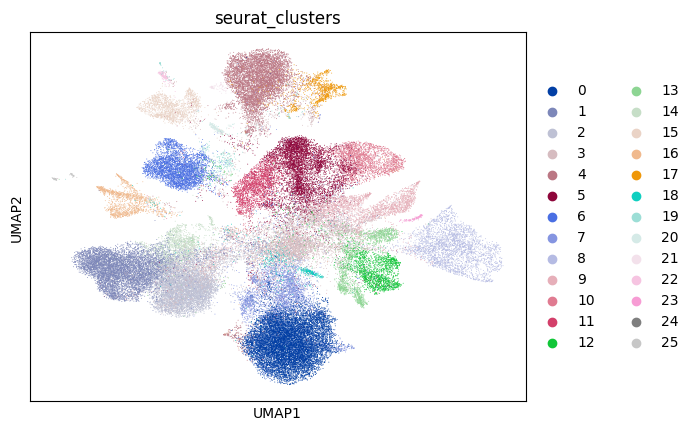

In [68]:

sc.pl.umap(adipose_sn_ad, color=[ 'seurat_clusters'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


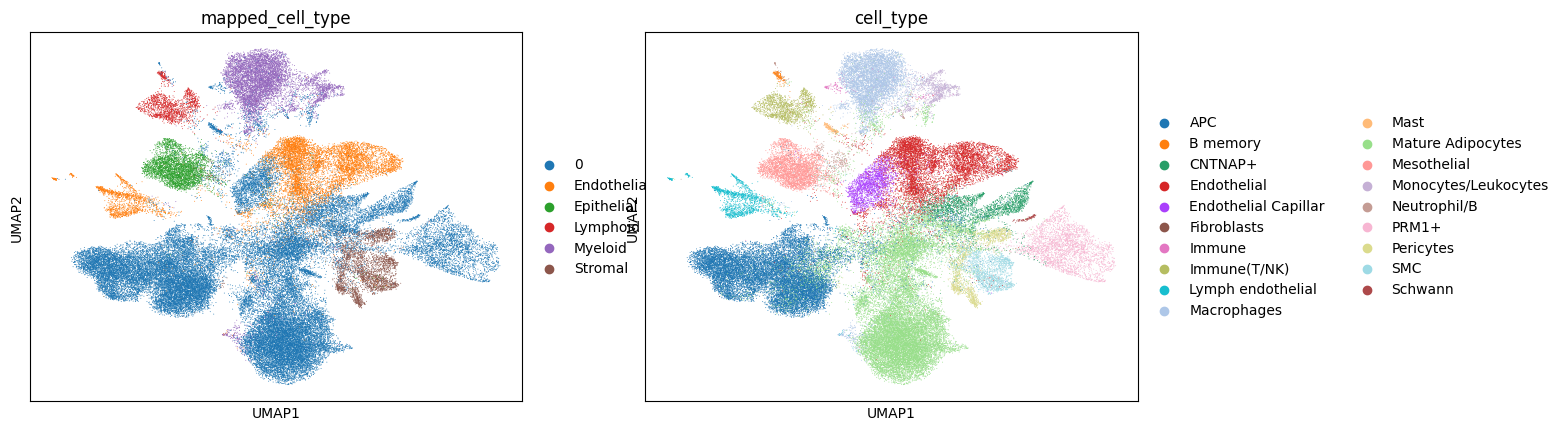

In [67]:
sc.pl.umap(adipose_sn_ad, color=[ 'mapped_cell_type', 'cell_type'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


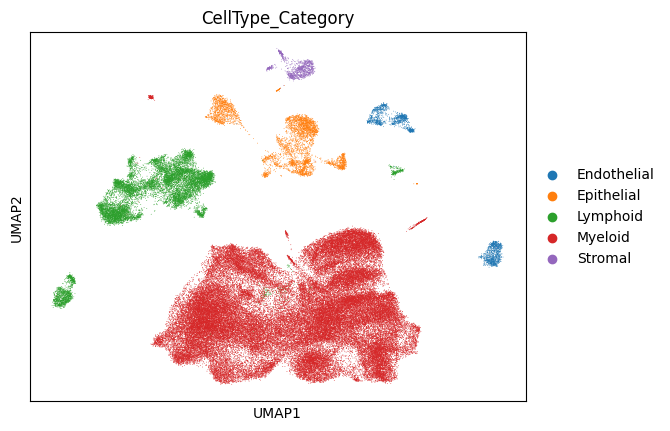

In [66]:
sc.pp.neighbors(healthy_human_lung, use_rep='X_uce')
sc.tl.umap(healthy_human_lung)
sc.pl.umap(healthy_human_lung, color=['CellType_Category'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


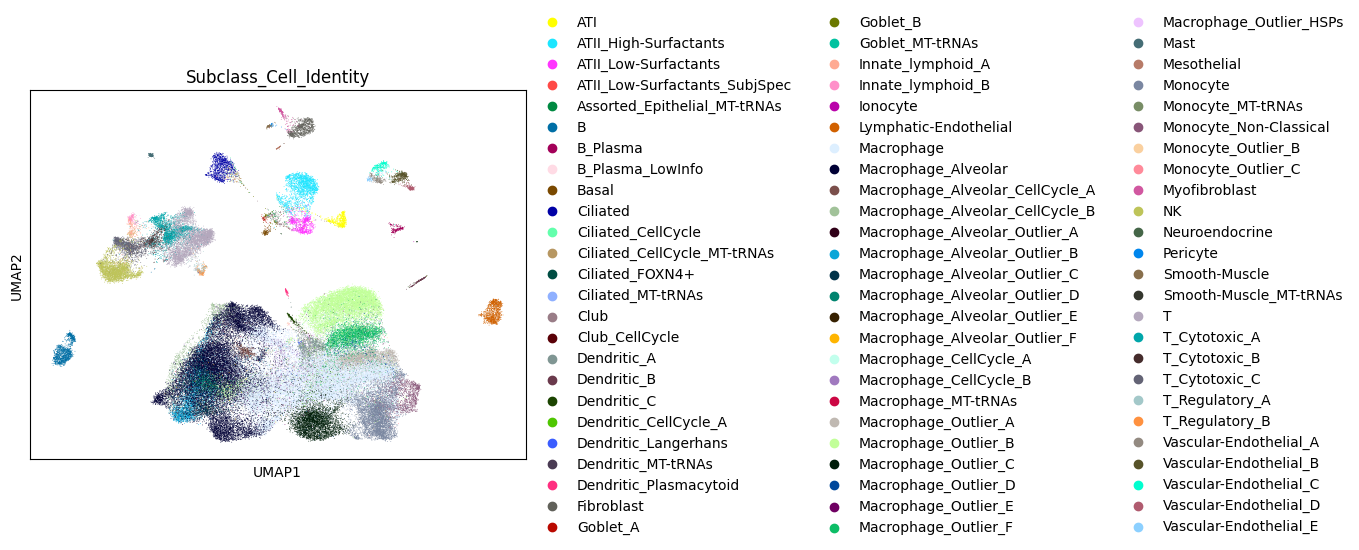

In [65]:
sc.pl.umap(healthy_human_lung, color=['Subclass_Cell_Identity'] )